# EnsembleOptimizer
In this notebook we demonstrate the basic usage of the `EnsembleOptimizer`, and how one can employ an ensemble of models (cluster expansions) to make predictions for the uncertainty of derived properties.

The `EnsembleOptimizer` will split the total dataset into many different training sets. Each of these will be used to train a cluster expansion, yielding a collection (or an ensemble) of cluster expansions.

The `EnsembleOptimizer` will thus produce a vector of predicted energies for a single structure. The spread (standard deviation) of these energies can to some extent be interpreted as the "uncertainty" for the given structure.

This can for example be useful when selecting training structures as described in Kleiven *et al.*, J. Phys. Energy **3**, 034012 (2021).

Furthermore each cluster expansion in the ensemble can be used to sample thermodynamic properties with MCMC, as demonstrated in the [icet paper](https://doi.org/10.1002/adts.201900015). This allows one for example to evaluate the sensitivity of the temperature-composition phase diagram with respect to training structures.

**Note:**
Generating an ensemble of models can also be done in a Bayesian framework, see, e.g., [this example](https://gitlab.com/materials-modeling/hiphive-examples/-/tree/master/advanced/bayesian_phonon_dispersions) for training force constant models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ase.db import connect
from icet import ClusterSpace, StructureContainer
from icet.tools import enumerate_structures
from trainstation import EnsembleOptimizer

In order to highlight how the analysis of the uncertainty of structures works in practice we construct cluster expansions for Ag-Pd from training structures with a maximum Pd concentration of 50%.
This should lead to models with large uncertainty for Pd concentrations above 50%, since the models have not seen (been trained on) any such structures.

In [2]:
# access database with reference data
db = connect('../../tutorial/reference_data.db')

# set up cluster space
primitive_structure = db.get(id=1).toatoms()
cs = ClusterSpace(
    structure=primitive_structure,
    cutoffs=[8.0, 6.5, 6.0],
    chemical_symbols=['Ag', 'Pd']
)

# compile fit data
sc = StructureContainer(cluster_space=cs)
for row in db.select():
    c_Pd = row.symbols.count('Pd') / row.natoms
    if c_Pd > 0.5:
        continue  # select only structures with 50% or less Pd

    sc.add_structure(
        structure=row.toatoms(),
        user_tag=row.tag,
        properties={'mixing_energy': row.mixing_energy},
    )
A, y = sc.get_fit_data(key='mixing_energy')
print('Fit data shape', A.shape)

Fit data shape (374, 64)


Now we train an ensemble of models.

In [3]:
fit_method = 'least-squares'
ensemble_size = 100

eopt = EnsembleOptimizer((A, y), fit_method=fit_method, ensemble_size=ensemble_size)
eopt.train()

## Uncertainty predictions for structures
Next we evaluate the uncertainty for a large collection of structures.

In [4]:
sizes = range(1, 9)
records = []
test_structures = []
for structure in enumerate_structures(primitive_structure, sizes, ['Pd', 'Ag']):
    c_Pd = structure.symbols.count('Pd') / len(structure)
    cv = cs.get_cluster_vector(structure)
    E_mean, E_std = eopt.predict(cv, return_std=True)
    
    row = dict(c_Pd=c_Pd, E_std=E_std, E_mean=E_mean)
    records.append(row)
    test_structures.append(structure)
df = pd.DataFrame(records)

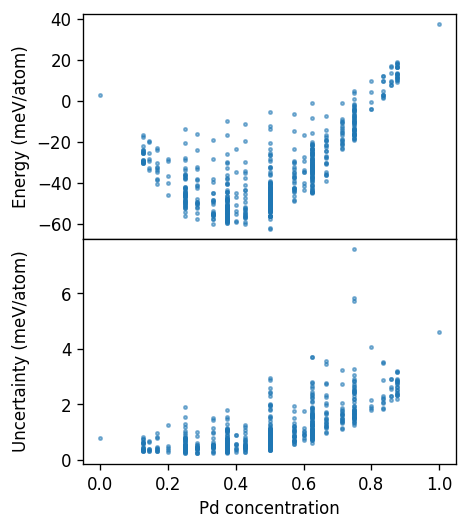

In [5]:
fig, axes = plt.subplots(
    figsize=(4, 4.5),
    dpi=120,
    sharex=True,
    nrows=2,
)

ax = axes[0]
conv = 1e3
ax.set_ylabel('Energy (meV/atom)')
ax.scatter(df.c_Pd, conv * df.E_mean, s=4, alpha=0.5)

ax = axes[1]
ax.set_xlabel('Pd concentration')
ax.set_ylabel('Uncertainty (meV/atom)')
ax.scatter(df.c_Pd, conv * df.E_std, s=4, alpha=0.5)

fig.tight_layout()
fig.subplots_adjust(hspace=0)
fig.align_ylabels(axes)

Here, we clearly see that structures with concentrations larger than 50% have much larger uncertainties, as expected. The uncertainty measure thus gives us a good indication of structures that are far away from the training structures and can therefore be used to suggest new training structures.

Selecting a new training structure could now, for example, be done as shown follows.

In [6]:
ind = df.E_std.idxmax()
structure = test_structures[ind]
print('New training structure suggestion:')
print(df.loc[ind])
print(structure)

New training structure suggestion:
c_Pd      0.750000
E_std     0.007598
E_mean    0.004762
Name: 27, dtype: float64
Atoms(symbols='Pd3Ag', pbc=True, cell=[[0.0, 0.0, 4.09], [0.0, 4.09, 0.0], [-4.09, 0.0, 0.0]])
